# Interoperability with Other Simulation Software
The python programming language is great for hooking together software. We include interoperability with a few useful programs to help expand the types of workflows that can be done.

## ASE Interoperability
The [Atomic Simulation Environment](https://wiki.fysik.dtu.dk/ase/) provides access to a whole host of quantum chemistry codes. With this in mind, we provide a conversion routine to use ASE calculators with BigDFT systems. First we create a system.

In [1]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.IO import XYZReader
from copy import deepcopy

sys = System()
reader = XYZReader("H2O")
sys["FRA:1"] = Fragment(xyzfile=reader)
sys["FRA:2"] = deepcopy(sys["FRA:1"])
sys["FRA:2"].translate([-5, 0, 0])

In [2]:
from BigDFT.Visualization import InlineVisualizer
viz = InlineVisualizer(300,200)
viz.display_system(sys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

For quick usage, you can directly compute the energy using an ASE calculator.

In [3]:
from ase.calculators.lj import LennardJones
from BigDFT.Interop.ASEInterop import ase_potential_energy
print(ase_potential_energy(sys, LennardJones()))

0.20284066010225557


You can also do a conversion from BigDFT system to ase Atoms so that you can use the full feature set.

In [4]:
from BigDFT.Interop.ASEInterop import bigdft_to_ase
from ase.optimize import BFGS
from ase.units import Hartree

asys = bigdft_to_ase(sys)
asys.set_calculator(LennardJones())
dyn = BFGS(asys)
dyn.run(fmax=0.05)
print(asys.get_potential_energy() / Hartree)

      Step     Time          Energy         fmax
BFGS:    0 16:39:50        5.519576       63.2394
BFGS:    1 16:39:50       -3.328517        3.4001
BFGS:    2 16:39:51       -3.486488        3.3784
BFGS:    3 16:39:51        7.593611       73.1586
BFGS:    4 16:39:51       -3.619863        3.3175
BFGS:    5 16:39:51       -3.743778        3.2154
BFGS:    6 16:39:51       13.439315      101.9495
BFGS:    7 16:39:51       -3.832216        3.1079
BFGS:    8 16:39:51       -3.913092        2.9772
BFGS:    9 16:39:51        3.594851       53.0443
BFGS:   10 16:39:51       -4.035308        2.7009
BFGS:   11 16:39:51       -4.131903        2.3812
BFGS:   12 16:39:51       -4.003748        6.5132
BFGS:   13 16:39:51       -4.331593        1.2274
BFGS:   14 16:39:51       -4.368607        0.7048
BFGS:   15 16:39:51       -4.376254        0.5923
BFGS:   16 16:39:51       -4.378013        0.5395
BFGS:   17 16:39:51       -4.433053        1.0824
BFGS:   18 16:39:51       -4.494141        2.3585
B

Just take care to convert back. Unfortunately, ASE has no concept of a named collection of fragments, so we can only automatically convert back to a fragment. You need to take care to rematch the fragments.

In [5]:
from BigDFT.Interop.ASEInterop import ase_to_bigdft
from BigDFT.Fragments import distance
frag = ase_to_bigdft(asys)
sys2 = System()
sys2["FRA:1"] = frag[0:3]
sys2["FRA:2"] = frag[3:]
print(distance(sys2["FRA:1"], sys2["FRA:2"]))

2.085749769735891


In [6]:
viz = InlineVisualizer(300,200)
viz.display_system(sys2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

ASE also offers all kinds of high level operations such as geometry optimization. You might want to use that to drive a BigDFT calculation. This can be done with our BigASECalculator. First, create your standard system calculator and input file.

In [7]:
from BigDFT.Inputfiles import Inputfile
from BigDFT.Calculators import SystemCalculator
inp = Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.4)
code = SystemCalculator()
code.update_global_options()

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft


Now bundle them into a BigASECalculator.

In [8]:
from BigDFT.Interop.ASEInterop import BigASECalculator
ase_code = BigASECalculator(inp, code)
print(ase_potential_energy(sys, ase_code))

Creating the yaml input file "./input.yaml"
Executing command:  mpirun -np 2 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft
-34.42723197438906


## Open Babel
Open babel offers a huge variety of features for cheminformatics. For example, we can compute the smiles representation of our system.

In [9]:
from BigDFT.Interop.BabelInterop import compute_smiles

In [10]:
print(compute_smiles(sys))

O.O


Or use openbabel's forcefields to compute the energy of a system.

In [11]:
from BigDFT.Interop.BabelInterop import system_energy
print(system_energy(sys, forcefield="UFF"))

0.00543185723335428


Or even optimize the geometry.

In [12]:
from BigDFT.Interop.BabelInterop import optimize_system
sys2 = optimize_system(sys, forcefield="uff")

In [13]:
print(system_energy(sys2))

0.005804044885758168


In [14]:
viz = InlineVisualizer(300,200)
viz.display_system(sys2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Direct conversion routines are available so that you can access the full feature set.

In [15]:
from BigDFT.Interop.BabelInterop import convert_system_to_babel
bsys = convert_system_to_babel(sys)
print(bsys.NumAtoms())

6


## XTB Interoperabilty
[XTB](https://xtb-docs.readthedocs.io/) is a program for performing semi-empirical calculations of systems. It has a rich feature set, so we have added an API that makes it similar to running BigDFT. First create a calculator.

In [16]:
from BigDFT.Interop.XTBInterop import XTBCalculator
code = XTBCalculator(skip=True)

Initialize a Calculator with OMP_NUM_THREADS=2 and command xtb


Running a calculation will return a logfile.

In [17]:
log = code.run(sys=sys, name="xtb-run")

Executing command:  echo "skip"


In [18]:
print(log.energy)
print(log.gradient_norm)

-10.135168148639
0.016864127201


XTB has two ways of adding options to your simulation. Unfortunately, some features are activated via the command line, and others via the input file. For example, let's try running some molecular dynamics of our system.

In [19]:
inp = {}
inp["md"] = {"temp": 300, "time": 2, "step": 1}

logmd = code.run(sys=sys, name="omd", md=True, inp=inp)


Executing command:  echo "skip"


Text(0.5, 0, 'Time')

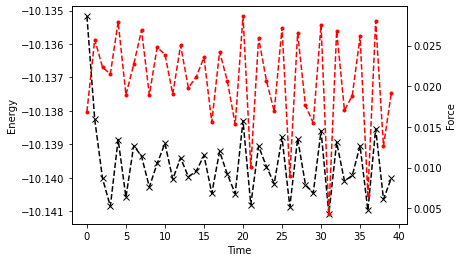

In [20]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1)
axs2 = axs.twinx()
axs.plot(logmd.md_energy, 'kx--')
axs2.plot(logmd.md_fnorm, 'r.--')
axs.set_ylabel("Energy")
axs2.set_ylabel("Force")
axs.set_xlabel("Time")

You will notice that to specify things like the temperature and number of steps, we had to use an input dictionary. This will be written in a straightforward way to XTB's input file.

In [21]:
with open("omd.tmol") as ifile:
    for line in ifile:
        print(line, end="")

$coord
  0.0 0.0 0.22166487441148175 o
  0.0 1.4309006215206648 -0.886659497645927 h
  0.0 -1.4309006215206648 -0.886659497645927 h
  -5.0 0.0 0.22166487441148175 o
  -5.0 1.4309006215206648 -0.886659497645927 h
  -5.0 -1.4309006215206648 -0.886659497645927 h
$end
$md
  temp=300
  time=2
  step=1
$end


However, to trigger an MD run, we had to pass the "omd" option to the run command. This is because it corresponds to a command line parameter. By carefully reading the XTB documentation, you should be able to access all of its features.

## PSI4 Interoperability
[PSI4](https://psicode.org/) is an ab initio quantum chemistry program. Beyond standard Hartree-Fock and DFT calculations, it can do a lot of post Hartree-Fock methods. One of its unique capabilities is efficient calculation of symmetry adapted perturbation theory to quantify inter-molecular forces.

PSI4 is in-fact a python based package, so you could do the interoperability yourself. We provide a procedure which can convert to a PSI4 type:

In [22]:
from BigDFT.Interop.PSI4Interop import bigdft_to_psi4
print(bigdft_to_psi4(sys))

We also provide a calculator to handle conversion automatically and extract quantities into a logfile. This calculator works like other calculators. You just have to specify the system, the basis set, the ab initio method, the action to take (energy, optimize, frequency), and any other options for psi4.

In [23]:
from BigDFT.Interop.PSI4Interop import PSI4Calculator
code = PSI4Calculator()

In [24]:
log = code.run(sys=sys, action="energy", basis="jun-cc-pvdz",
                        psi4_options={"scf_type": "direct"}, method="scf", name="psi4-run")

The logfile is basically just a dictionary, so you can inspect it to see what values were extracted (which depend on the action and possibly the method). You can also parse the output of psi4 yourself by accessing the line split internal logfile.

In [25]:
print(log)

{'energy': {'total': -152.0602609128111}}


In [26]:
print("\n".join(log.log[4:9]))

   => Loading Basis Set <=

    Name: JUN-CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS


To do an SAPT calculation, just specify the method as one of the available SAPT methods. Additionally, you need to pass a system which has exactly two fragments in it.

In [27]:
log = code.run(sys=sys, action="energy", basis="jun-cc-pvdz", method="sapt0", name="psi4-sapt-run")

In [28]:
print(log)

{'energy': {'sapt0': {'electrostatics': 0.00348873311, 'exchange': 0.012796787950000001, 'induction': -0.00118507077, 'dispersion': -0.00151177894, 'total': 0.01510045029}, 'sSAPT0': {'electrostatics': 0.00348873311, 'exchange': 0.012796787950000001, 'induction': -0.00109741424, 'dispersion': -0.00149617961, 'total': 0.0136919272}}}


It is also possible to do geometry optimization.

In [29]:
log = code.run(sys=sys, action="optimize", basis="6-31g",
                       method="scf", name="psi4-sapt-opt")

Optimizer: Optimization complete!


Text(0.5, 0, 'Step')

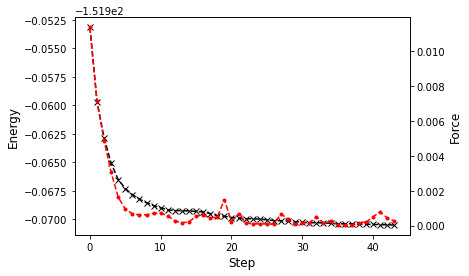

In [32]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1)
axs2 = axs.twinx()
axs.plot(log["energy"]["optimize"], 'kx--')
axs2.plot(log["max force"], 'r.--')
axs.set_ylabel("Energy", fontsize=12)
axs2.set_ylabel("Force", fontsize=12)
axs.set_xlabel("Step", fontsize=12)